## Analyze A/B Test Results
This is an educational project from Udacity's Data Analysis Advanced Nanodegree.

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusions](#conclusions)
- [Recommendations](#recommendations)

<a id='intro'></a>
### Introduction

An e-commerce company conducted an A/B to understand if they should implement a new page, keep the old page, or perhaps run the experiment longer to make their decision. In this notebook, we analyze the results and recommend a decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
# The random seed is set for project review purposes
random.seed(42)

Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Shape the dataset.

In [3]:
df.shape

(294478, 5)

In [4]:
df.group.unique(), df.landing_page.unique()

(array(['control', 'treatment'], dtype=object),
 array(['old_page', 'new_page'], dtype=object))

The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

The proportion of users converted.

In [6]:
print('including duplicate users: ',df.converted.mean())
print('unique users: ', df.query('converted == 1').user_id.nunique()/df.user_id.nunique())

including duplicate users:  0.11965919355605512
unique users:  0.12104245244060237


The number of times the `new_page` and `treatment` don't line up.

In [7]:
condition1 = (df.group == 'treatment') & (df.landing_page != 'new_page')
condition2 = (df.group != 'treatment') & (df.landing_page == 'new_page')
len(df[condition1 | condition2])

3893

f. Do any of the rows have missing values?

In [8]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

g. For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. We'll create a new data frame omitting these results.

In [9]:
df2 = df[~((df.group == 'treatment') == (df.landing_page != 'new_page'))].copy()

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

How many unique **user_id**s are in **df2**?

In [11]:
print(df2.user_id.nunique())
print(len(df2))

290584
290585


There is one **user_id** repeated in **df2**.  What is it?

In [12]:
repeated_user = df2[df2.user_id.duplicated()].user_id.item()
repeated_user

773192

What is the row information for the repeat **user_id**? 

In [13]:
df2[df2.user_id == repeated_user]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove **one** of the rows with a duplicate **user_id**.

In [14]:
df2.drop(index = df2[df2.user_id == repeated_user].index[0], inplace=True)

In [15]:
#check
df2[df2.user_id == repeated_user]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


What is the probability of an individual converting regardless of the page they receive?

In [16]:
# all users are unique now, so no need to check for both duplicates and unique
df2.converted.mean()

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
control_conv = df2.query("group == 'control'").converted.mean()
control_conv

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
treat_conv = df2.query("group == 'treatment'").converted.mean()
treat_conv

0.11880806551510564

What is the probability that an individual received the new page?

In [19]:
(df2.landing_page == 'new_page').mean()

0.5000619442226688

In [20]:
#making sure we get the same result
(df2.group == 'treatment').mean()

0.5000619442226688

Is there sufficient evidence to say that the new treatment page leads to more conversions?

**Answer** <br><br>
There is no sufficient evidence that the new treatment page leads to more conversations.
- 50% of the group is treatment, so we're even comparing ratios considering the same number of people for both control and treatment groups.
- 12.03% of the control group converted and 11.88% of the treatment group converted, so the control group actually has a slightly higher conversion rate, indicating that the new page is not better considering our analysis so far.

<a id='ab_test'></a>
### Part II - A/B Test

Consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Answer** <br>
$$H_0: P_{new} - P_{old} \leq 0$$
$$H_1: P_{new} - P_{old} \gt 0$$
$$\alpha = 0.05$$

Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

What is the **convert rate** for $p_{new}$ under the null? 

In [21]:
p_new_null = df2.converted.mean()
p_new_null

0.11959708724499628

What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [22]:
p_old_null = df2.converted.mean()
p_old_null

0.11959708724499628

What is $n_{new}$?

In [23]:
n_new = (df2.landing_page == 'new_page').sum()
n_new

145310

What is $n_{old}$?

In [24]:
n_old = (df2.landing_page == 'old_page').sum()
n_old

145274

Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.binomial(1, p_new_null, n_new)

Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.binomial(1, p_old_null, n_old)

Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
new_page_converted.mean() - old_page_converted.mean()

-0.0012961790942613849

Simulate 10,000 $p_{new}$ - $p_{old}$ values. Store all 10,000 values in a numpy array called **p_diffs**.

In [28]:
new_converted_simulation = np.random.binomial(n_new, p_new_null, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old_null, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

In [29]:
p_diffs = np.array(p_diffs)

Plot a histogram of the **p_diffs**.

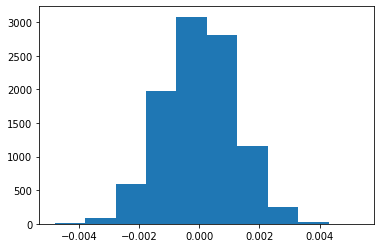

In [30]:
plt.hist(p_diffs);

What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
obs_diff = treat_conv-control_conv
obs_diff

-0.0015782389853555567

In [32]:
(p_diffs > obs_diff).mean()

0.9059

What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer**<br><br>
We just calculated the *__p-value__*. In our case, it means that: Given that the null hypothesis $H_0: P_{new} - P_{old} \leq 0$ is true, there is a *__0.9035__* chance of obtaining our observed statistic *__-0.0015__* (which is the difference in mean) or a more extreme value in favor of the alternative hypothesis.

statsmodels Z-Test

In [33]:
import statsmodels.api as sm

convert_old = df2.query("landing_page == 'old_page'").converted.sum()
convert_new = df2.query("landing_page == 'new_page'").converted.sum()

#n_old and n_new are already calculated and save previously

In [34]:
sm.stats.proportions_ztest(count=[convert_new, convert_old], nobs=[n_new, n_old], value=0, alternative='larger')

(-1.3109241984234394, 0.9050583127590245)

What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the you previous findings?

**Answer**

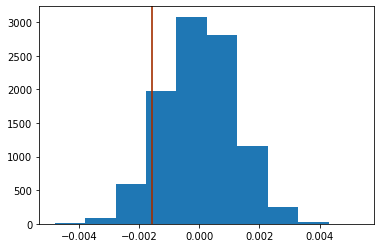

In [35]:
#visualizing the results

plt.hist(p_diffs)
plt.axvline(p_diffs.std()*-1.31, color='red', alpha=1)
plt.axvline(obs_diff, color='green', alpha=0.4)

The z-score computed is *-1.31* which means that the *observed difference* was located at *-1.33 standard deviations away from the mean of the normal distribution.* As we can see in the above graph, the observed difference and the z-score are aligned which confirms our understanding. The *p-value* was similar to what we calculated earlier with only a 0.0015 difference, which indicates that __*We fail to reject the null hypothesis*__

<a id='regression'></a>
### Part III - A regression approach

Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer**: Logestic Regression

Create intercept and dummy columns.

In [36]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2.landing_page).loc[:, 'new_page']

In [37]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created to predict whether or not an individual converts.

In [38]:
lm = sm.Logit(df2.converted, df2[['intercept', 'ab_page']])
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2023-01-12 10:46 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found previously?

**Answer**: The *p-value* for `ab_page` is **0.1899**. It differs from the value we computed earlier because the null and alternative hypotheses are not the same. We previously used $H_0: P_{new} - P_{old} \leq 0$ as our null, here we are using $H_0: P_{new} - P_{old} \neq 0$. We can confirm this by repeating the z-test and matching our null hypothesis.

In [40]:
#using the null hypothesis as the logestic regression model
sm.stats.proportions_ztest(count=[convert_new, convert_old], nobs=[n_new, n_old], value=0, alternative='two-sided')

(-1.3109241984234394, 0.18988337448195103)

We get the exact same *z-score* and *p-value* as our logestic regression model.

Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

In [41]:
df.timestamp.min(), df.timestamp.max()

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

**Answer**<br><br>
Considering other factors would be beneficial because we can get a deeper insight of how to improve our conversion rate. In our model we are assuming that the only factor affecting the conversion rate is the landing page, which is not necessarily true.<br>However, by adding more terms we make the model more complicated and prone to errors, and we shift the focus away from our main question: which landing page is better for our conversion rate?

Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset. 

Does it appear that country had an impact on conversion?

In [42]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [43]:
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [44]:
# we will make US our baseline
df_new[['ca', 'uk']] = pd.get_dummies(df_new.country).loc[:, ['CA', 'UK']]

In [45]:
lm2 = sm.Logit(df_new.converted, df_new[['intercept', 'ab_page', 'ca', 'uk']])
results2 = lm2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2023-01-12 10:46 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
ca           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
uk            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

In [46]:
print(f'CA residents are {1/np.exp(-0.0408)} times less likely to convert than the US')
print(f'UK residents are {np.exp(0.0099)} times more likely to convert than the US')

CA residents are 1.0416437559600236 times less likely to convert than the US
UK residents are 1.0099491671175422 times more likely to convert than the US


It appears that country has no statistical significance on the output as the *p-values* were < 0.05

Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [47]:
df_new['ab_page_ca'] = df_new.ab_page * df_new.ca
df_new['ab_page_uk'] = df_new.ab_page * df_new.uk

In [48]:
lm3 = sm.Logit(df_new.converted, df_new[['intercept', 'ab_page', 'ca', 'uk', 'ab_page_ca', 'ab_page_uk']])
results3 = lm3.fit()
results3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2023-01-12 10:46 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
ca           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
uk           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
ab_page_ca   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
ab_page_uk    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

There are still no statistically significent results. However we can note that the `uk` coef. changed to negative, while the `ab_page_uk` is positive which can indicate that UK citizens who are in the treatment group are more likely to convert are more likely to convert than US citizens in the treament group. *But I'm not sure if this is a correct interpretation*

<a id='conclusions'></a>
## Conclusions

An **A/B test** was conducted using multiple approaches to determine if **implementing a new web page** will increase the conversion rate of the users.<br>The following methods were used:
1. Generating a random sample under the null hypothesis and calculating the p-value using the observed difference.
2. Using a two sample z-test.
3. Fitting a logestic regression model.


The experiment ran for **22 days** with a total of **290584 unique users** split between the new and old landing pages. We also conducted further tests to determine whether the **country** had a significant effect.<br>The following hypothesis was used, where **P** is the conversion rate:
$$H_0: P_{new} - P_{old} \leq 0$$
$$H_1: P_{new} - P_{old} \gt 0$$
$$\alpha = 0.05$$
**Results:**
- The old page had a 12.04% conversion rate.
- The new page had a 11.88% conversion rate.
- The observed difference was -0.16% (new - old).
- The landing page showed no statistically or practically significant results with a computed *p-value* of 0.905 using 2 testing methods:
    - Generating a random sample under the null  hypothesis.
    - Using a two sample z-test.
- The logestic regression model showed similar results, where no statistically significant results was found.
- The country of the users was considered in another model, as well as the interaction between the country and the landing page. No statistically significant results were found in either models.

**Therefore: We fail to reject the null hypothesis given the current information**
<a id='recommendations'></a>
## Recommendations:
- Keep the old landing page.
- If possible, run the test for a longer period of time to have more reliable results.
- We may consider more variables in future analyses to gain a more in-depth insight of the factors affecting the conversion rate such as:
    - Duration of the visit.
    - Time of the visit.